In [28]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression, ElasticNet

folder = r"E:\GoogleDrive\NYU_MathFin\3rd_semester\DS_in_Finance\Project\dataset\\"

In [2]:
all_data = pd.read_csv(folder + r"Predictors.csv", index_col = 0, parse_dates = True)
all_data = all_data.fillna(method = 'ffill')
all_data = all_data.fillna(method = 'bfill')
y_data = all_data['SPX'].copy()
y_data = y_data.pct_change(130).shift(-130)
x_data = all_data.copy()
del x_data['SPX']
print all_data.isnull().any()
print type(all_data.index[0])

BM          False
PE          False
CAPE        False
DP          False
PCAprice    False
CPI         False
SPX         False
BY          False
DEF         False
VRP         False
IC          False
BDI         False
PCR         False
MA          False
PCAtech     False
OIL         False
SI          False
dtype: bool
<class 'pandas._libs.tslib.Timestamp'>


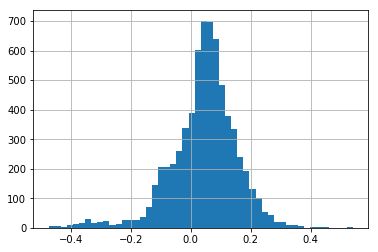

In [3]:
y_data.hist(bins = 50)

In [4]:
#data_date = pd.read_csv(folder + r'dataset\DATE.csv', index_col = 0, parse_dates = [0,1,2])

In [33]:
class VariableSelector(object):
    def __init__(self, X,Y, **kwargs):
        self.X = X
        self.Y = Y
        self.xnames = X.columns.values
        self.X_trans = self.X.copy()
        self.model = LinearRegression()
        self.xusednames = self.xnames
        self.transMethods = None
        self.dataInventDateInfo = pd.read_csv(folder + r'DATE.csv', index_col = 0, parse_dates = [0,1,2,3])
        self.useTransformation = kwargs.get('useTransformation') or False #useTransformation
    '''
    def __setTransformForOne(self, col, has_negative = False):
        # If there's negative value, cannot use log
        tmp = self.X[[col]]
        transMethod = ['raw','ewma', 'log']
        tmp.columns = ['raw']
        tmp['ewma'] = pd.ewma(tmp['raw'], alpha = 0.94)
        tmp['log'] = tmp['raw'].apply(np.log)
        tmp['log'] -= tmp['log'].rolling(5).mean().mean()
        tmp['log'] = tmp['log'].fillna(method = 'bfill')
        tmp['sp_lag'] = self.Y.copy()
        corr = tmp.corr().as_matrix()[-1,:-1]
        corr_abs = abs(corr)
        if has_negative:
            corr_abs[2] = -100
        chosen = transMethod[np.argmax(corr_abs)]
        self.X_trans[col] = tmp[chosen]
        return chosen, np.max(corr_abs)
    
    def __setTransformForOne(self, col, has_negative = False):
        # If there's negative value, cannot use log
        tmp = self.X[[col]]
        transMethod = ['raw','ewma']
        tmp.columns = ['raw']
        tmp['ewma'] = pd.ewma(tmp['raw'], alpha = 0.94)
        tmp['sp_lag'] = self.Y.copy()
        corr = tmp.corr().as_matrix()[-1,:-1]
        corr_abs = abs(corr)
        chosen = transMethod[np.argmax(corr_abs)]
        self.X_trans[col] = tmp[chosen]
        #print col, chosen
        return chosen, np.max(corr_abs)
    '''
    def __setTransformForOne(self, col):
        # If there's negative value, cannot use log
        if self.dataInventDateInfo['start date'][col] >= self.X.index[0]:
            del self.X_trans[col]
            return 'discard',np.nan
        elif not self.useTransformation:
            self.X_trans[col] = self.X[col]     
            return 'raw', abs(np.corrcoef(self.X_trans[col], self.Y)[1,0])
        else:
            tmp = self.X[[col]]
            tmp.columns = ['raw']
            transMethod = ['raw','ewma']
            tmp['ewma'] = pd.ewma(tmp['raw'], alpha = 0.94)
            
            tmp['sp_lag'] = self.Y.copy()
            corr = tmp.corr().as_matrix()[-1,:-1]
            corr_abs = abs(corr)
            chosen = transMethod[np.argmax(corr_abs)]
            self.X_trans[col] = self.X[[col]]
            return chosen, np.max(corr_abs)
    
    def selectVariables(self):
        transMethods = {}
        corrCoefs = {}
        for col in self.xnames:
            thisMethod, thisCorr = self.__setTransformForOne(col)
            transMethods[col] = thisMethod
            corrCoefs[col] = thisCorr

        self.transMethods = transMethods
        self.corrCoefs = corrCoefs
        self.Y = self.Y.fillna(0)##########
        
    def transformOutSample(self, outSampleX):
        outSampleX_trans = outSampleX.copy()
        for key,value in self.transMethods.items():
            if value == 'raw':
                continue
            elif value == 'log':
                outSampleX_trans[key] = outSampleX[key].apply(np.log)
                outSampleX_trans[key] -= outSampleX[key].rolling(5).mean()
                outSampleX_trans[key] = outSampleX_trans[key].fillna(method = 'bfill')
            elif value =='ewma':
                outSampleX_trans[key] = pd.ewma(outSampleX[key], alpha = 0.94)
            elif value == 'discard':
                del outSampleX_trans[key]
        return outSampleX_trans

In [34]:
class corrSelector(VariableSelector):
    def __init__(self, X, Y, **kwargs):
        super(corrSelector, self).__init__(X, Y, **kwargs)
        self.threshold = kwargs.get('threshold') or 0.1  
    def selectVariables(self):
        super(corrSelector, self).selectVariables()
        for key, value in self.corrCoefs.items():
            if value < self.threshold:
                self.transMethods[key] = 'discard'
                del self.X_trans[key]
        #print self.corrCoefs
        #print self.transMethods
    def transformOutSample(self, outSampleX):
        outSampleX_trans = super(corrSelector, self).transformOutSample(outSampleX)
        for key,value in self.transMethods.items():
            if value == 'discard' and key in outSampleX_trans.columns:
                del outSampleX_trans[key]
        return outSampleX_trans    

In [35]:
class realTimeCorrSelector(corrSelector):
    def __init__(self, X, Y, **kwargs):
        super(realTimeCorrSelector, self).__init__(X, Y, **kwargs)
    
    def selectVariables(self):
        super(realTimeCorrSelector, self).selectVariables()
        for key, value in self.transMethods.items():
            if self.dataInventDateInfo['discover date'][key] >= self.X.index[0]:
                self.transMethods[key] ='discard'
                if key in self.X_trans.columns:
                    del self.X_trans[key]                     

In [36]:
class ReturnPredictor(object):
    def __init__(self, X, Y, 
                 firstTestDay = datetime.datetime(2000, 1, 1), 
                 Selector = VariableSelector, 
                 model = LinearRegression(),
                 **kwargs
                ):
        self.X = X
        self.Y = Y
        self.Y_fit  = self.Y.copy() * 0.0
        self.Y_pred = self.Y.copy() * 0.0
        self.firstTestDay = firstTestDay# datetime.datetime(2000, 1, 1)
        self.__setSampleScope(trainset_endday = self.firstTestDay)
        self.Selector = Selector
        self.selectorParams = kwargs
        self.model = model
        
        
    def __setSampleScope(self, trainset_startday = None, trainset_endday = None):
        if trainset_startday:
            self.trainset_startday = trainset_startday
            self.trainset_endday = datetime.datetime(self.trainset_startday.year + 10, 
                                                 self.trainset_startday.month, 
                                                 1)
        elif trainset_endday:
            self.trainset_endday = trainset_endday
            self.trainset_startday = datetime.datetime(self.trainset_endday.year - 10, 
                                                   self.trainset_endday.month, 
                                                   1)
        self.insample_X = self.X[(self.X.index >= self.trainset_startday) & (self.X.index <= self.trainset_endday)]
        self.insample_Y = self.Y[(self.Y.index >= self.trainset_startday) & (self.Y.index <= self.trainset_endday)]
        if self.trainset_endday.month == 12:
            self.testset_endday = datetime.datetime(self.trainset_endday.year + 1, 1, 1)
        else:
            self.testset_endday = datetime.datetime(self.trainset_endday.year, self.trainset_endday.month + 1, 1)
        self.outsample_X = self.X[(self.X.index >= self.trainset_endday) & (self.X.index <= self.testset_endday)]
        self.outsample_Y = self.Y[(self.Y.index >= self.trainset_endday) & (self.Y.index <= self.testset_endday)]
        
        
    def __resetSampleScope(self):
        self.__setSampleScope(trainset_endday = self.testset_endday + datetime.timedelta(days = 1))
    
        
    def fitOneSample(self):
        thisSample = self.Selector(self.insample_X, self.insample_Y, **self.selectorParams)
        thisSample.selectVariables()
        self.insampleX_trans = thisSample.X_trans
        self.model.fit(self.insampleX_trans, self.insample_Y)
        self.outsampleX_trans = thisSample.transformOutSample(self.outsample_X)
        self.insampleY_fit = self.model.predict(thisSample.X_trans)
        self.outsampleY_pred = self.model.predict(self.outsampleX_trans)
        
        self.Y_fit.loc[self.insample_Y.index] = self.insampleY_fit
        self.Y_pred.loc[self.outsample_Y.index] = self.outsampleY_pred
    
    def fitAll(self, endDate = None):
        self.modelEndDate = endDate or self.X.index[-1]
        while self.testset_endday <= self.modelEndDate:
            self.fitOneSample()
            self.__resetSampleScope()
        self.Y_pred = self.Y_pred[self.Y_pred.index >= self.firstTestDay]
        
    def plotLastPrediction(self):
        in_tmp = self.insample_Y.to_frame().copy()
        in_tmp.columns = ['real']
        in_tmp['pred'] = self.insampleY_pred
        out_tmp = self.outsample_Y.to_frame().copy()
        out_tmp.columns = ['real']
        out_tmp['pred'] = self.outsampleY_pred
        in_tmp.plot()
        out_tmp.plot()
    
    def plotAllPrediction(self, showFittedLine = False):
        tmp = self.Y.to_frame().copy()
        tmp.columns = ['real']
        tmp = tmp[tmp.index >= self.firstTestDay]
        tmp['pred'] = self.Y_pred
        tmp = tmp[tmp.index <= self.modelEndDate]
        if showFittedLine:
            tmp['fit']  = self.Y_fit[self.Y_fit.index >= self.firstTestDay]
        tmp.plot()

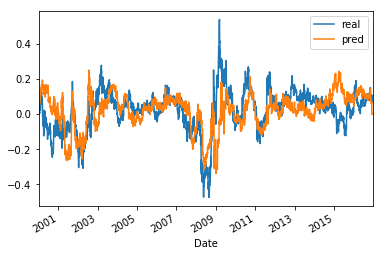

In [40]:
xxx = x_data[x_data.index <= datetime.datetime(2017, 1, 1)]
yyy = y_data[y_data.index <= datetime.datetime(2017, 1, 1)]
# Simple Linear Regression
model1 = ReturnPredictor(xxx,yyy, 
                      Selector = VariableSelector, 
                      model = LinearRegression(),
                      useTransformation = False)
model1.fitAll()
model1.plotAllPrediction()

In [38]:
model1.Y_pred.to_csv(folder + "simpLR.csv")

D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.94).mean()
D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\ProgramFiles\Anaconda2\lib\site-packages\ipykernel_launcher.py:88

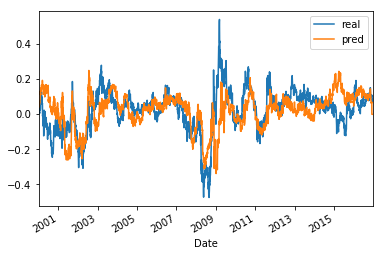

In [41]:
# Simple Linear Regression with transformation
model2 = ReturnPredictor(xxx,yyy, 
                      Selector = VariableSelector, 
                      model = LinearRegression(),
                      useTransformation = True)
model2.fitAll()
model2.plotAllPrediction()

In [42]:
model2.Y_pred.to_csv(folder + "LR_withTransform.csv")

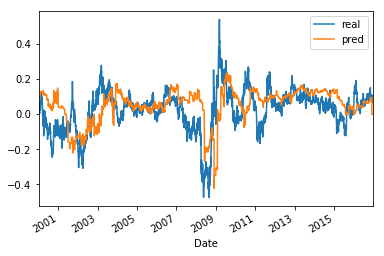

In [43]:
# Correlation screen, without transformation
model3 = ReturnPredictor(xxx,yyy,
                      Selector = corrSelector, 
                      model = LinearRegression(),
                      useTransformation = False,
                      threshold = 0.2
                     )
model3.fitAll()
model3.plotAllPrediction()

In [44]:
model3.Y_pred.to_csv(folder + "corrLR.csv")

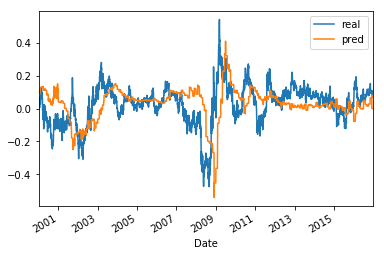

In [46]:
# Real time correlation screen, without transformation
model4 = ReturnPredictor(xxx,yyy,
                      Selector = realTimeCorrSelector, 
                      model = LinearRegression(),
                      useTransformation = False,
                      threshold = 0.2
                     )
model4.fitAll()
model4.plotAllPrediction()

In [47]:
model4.Y_pred.to_csv(folder + "real_corrLR.csv")

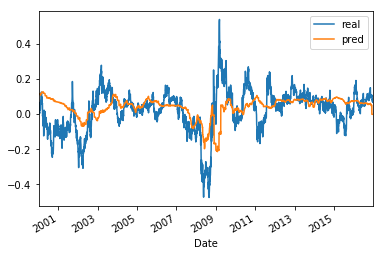

In [48]:
# Elastic Net regression
model5 = ReturnPredictor(xxx,yyy,
                      Selector = VariableSelector, 
                      model = ElasticNet(alpha = 0.5,
                                        l1_ratio = 0.3),
                      useTransformation = False,
                     )
model5.fitAll()
model5.plotAllPrediction()

In [49]:
model5.Y_pred.to_csv(folder + "elasticNet.csv")